# Lab: Knowledge Distillation

<a href="https://creativecommons.org/licenses/by-nc/4.0/">
  <img src="https://licensebuttons.net/l/by-nc/4.0/88x31.png" alt="CC BY-NC 4.0" style="vertical-align:middle;">
</a>
<span style="vertical-align:middle; margin-left:8px;">
  <strong>CC BY‑NC 4.0</strong> — non‑commercial use with attribution.  
  Full terms at the link.
</span>

<br>
<br>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](
https://colab.research.google.com/github/antoninofurnari/deeplearning/blob/main/notebooks/07-04-26-knowledge-distillation.ipynb
)

**Course:** Deep Learning: Advanced Models and Methods

**Instructor:** Antonino Furnari

**Duration:** 2 Hours (In-class Group Lab)

## 📝 Lab Format & Deliverables
* **Format:**
  * Students work in groups of 1-3.
  * The teacher gives a brief introduction to the lab, then students work independently with support from the teacher.
* **Strategy:**
  * Fill in the ☑️ `TODO` blocks. Do not modify the provided boilerplate unless necessary.
  * Check that you obtained reasonable results through the 🛑 `Checkpoints`.
  * Fill in the short 📝 `Reflections` where required.
  * Reach 🏁 `Milestones`.
* **Submission:**
  * Fill in this notebook and send it to <antonino.furnari@unict.it> as an `.ipynb` by the end of the lab
* **Grading:**
  * Notebooks will be graded in binary way as passed / not passed based on completion (did the group reach all milestones successfully? are reflections adequate?)
  * Each notebook is worth $0.5$ bonus points. These are assigned to students individually (not to groups).
* **Computation:**
  * Run this notebook on Google Colab or Kaggle with GPU acceleration.

You will find the following blocks throughout the notebook:

> ☑️ **TODO**
>
> This box provides you instruction on a TODO that should be completed in the code cells below.

> 🛑 **Checkpoint**
>
> The following cells provide you instruction on what you should observe if you run a given cell after having implemented your TODOs. This serve as a self-check to assess potential bugs or errors early.


> 📝 **Reflection**
>
> You are required to write a short reflection on your results.

> 🏁 **Milestone**
>
> This signal that you completed a significant part of the notebook and reached a milestone.

## Your Data
> 📝 **Date and Team Composition**
>
> <i>Insert the current date, plus names, surnames, matricola, and emails of the team members below:</i>
>
> **Date:** YYYY-MM-DD
>
> **Link to wandb:** <a href="example_link">link</a>
>
> | Name | Surname | Matricola | Email |
> |---|---:|---:|---|
> | Name 1 | Surname1 | 0000001 | <a href="mailto:member1@example.com">member1@example.com</a> |
> | Name 2 | Surname2 | 0000002 | <a href="mailto:member2@example.com">member2@example.com</a> |
> | Name 3 | Surname3 | 0000003 | <a href="mailto:member3@example.com">member3@example.com</a> |

## Introduction and Problem Setup

### 🎯 Learning Goals

In this lab, you will dive into the **"Why"** and **"How"** of model compression through the lens of **Knowledge Distillation (KD)**.

You will implement the foundational mechanisms that allow a compact "Student" model to inherit the complex decision-making of an overparameterized "Teacher".

By the end of this session, you will:

1. **Extract "Dark Knowledge"**: Implement temperature-scaled softmax to reveal the structural class relationships hidden in a teacher's probability distributions.


2. **Bridge the Inference Gap**: Train a lightweight student model to perform effectively in resource-constrained environments by mimicking a powerful teacher.


3. **Evaluate Structural Transfer**: Compare standard classification baselines against distilled students using visual proofs like t-SNE manifolds.



### Problem Setup

We face a growing conflict in modern AI known as the **Inference Gap**:

* **The Training Reality**: Models are trained on massive cloud infrastructure (e.g., NVIDIA A100 GPUs) with billions of parameters to navigate complex loss landscapes.


* **The Deployment Constraint**: These models must often run on hardware with strict latency requirements (sub-100ms) and limited memory (megabytes), such as mobile phones, IoT sensors, or autonomous vehicles.

Standard training often results in **overparameterization**—networks that contain significant redundancy once trained. Knowledge Distillation solves this by extracting the "essence" of the solution into a smaller, optimized network.

#### The Dataset: CIFAR-10

For this laboratory, we use **CIFAR-10**, a collection of 60,000 32x32 color images in 10 classes (e.g., airplane, bird, cat, deer).

<img src="https://docs.pytorch.org/tutorials/_static/img/cifar10.png">

While seemingly simple, CIFAR-10 allows us to observe **Dark Knowledge** in action. For instance, a well-trained model knows a "cat" is visually closer to a "dog" than it is to an "airplane," as shown by the small non-zero probabilities it assigns to similar classes during prediction.

#### The Core Mechanism: Temperature Scaling

A major challenge is that standard models produce **"Spiky" distributions**, where the correct class has a probability near 1.0, masking intricate similarities. We will introduce a **Temperature ($T$) hyperparameter**:

* **$T=1$**: Standard, aggressive Softmax.


* **$T > 1$**: "Softens" the distribution, highlighting the relative heights of incorrect classes to reveal the teacher's internal processing flow.



#### Why Distillation Matters

Distillation is more than simple regularization; it is a **Structural Transfer**. While methods like Label Smoothing treat all errors equally, KD tells the student exactly *how* classes resemble one another, preserving the geometric structure of the data manifold.

#### Note
Parts of this notebook are adapted from Alexandros Chariton's tutorial on Knowledge Distillation in PyTorch: https://docs.pytorch.org/tutorials/beginner/knowledge_distillation_tutorial.html

## Preparation

We will start by installing necessary packages and logging in to `wandb`. Please create an account if you don't have it already.


In [1]:
# @title ⚙️ Setup and Imports
# Install necessary libraries (quiet mode)
!pip install -q pytorch-lightning wandb

import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_lfw_people
from sklearn.metrics import accuracy_score, average_precision_score
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
import torchvision.datasets as datasets

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torchvision import models, transforms
import pytorch_lightning as pl
from pytorch_lightning.loggers import WandbLogger
import wandb

# Set global seed for reproducibility
pl.seed_everything(42)

# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"✅ Setup complete. Using device: {device}")

# Weights & Biases Login
WANDB_PROJECT = "dl-lab-knowledge-distillation"
print("\n🚀 Logging in to Weights & Biases...")
try:
    # This will prompt you for your API key if not already logged in
    wandb.login()
    print(f"✅ Login successful! Runs will be logged to project: '{WANDB_PROJECT}'")
except Exception as e:
    print(f"⚠️ Login failed: {e}")
    print("⚠️ Switching to OFFLINE mode. Metrics will be saved locally.")
    os.environ["WANDB_MODE"] = "offline"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 857.3/857.3 kB 28.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 62.3 MB/s eta 0:00:00


INFO:lightning_fabric.utilities.seed:Seed set to 42


✅ Setup complete. Using device: cuda

🚀 Logging in to Weights & Biases...


/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice:

 2


wandb: You chose 'Use an existing W&B account'
wandb: Logging into https://api.wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: Create a new API key at: https://wandb.ai/authorize?ref=models
wandb: Store your API key securely and do not share it.
wandb: Paste your API key and hit enter:

 ··········


wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: antoninofurnari to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


✅ Login successful! Runs will be logged to project: 'dl-lab-knowledge-distillation'


The following cell defines some hyperparameters we will reference later:

In [2]:
# @title 💾 Configuration & Data Loading
# CONFIGURATION
BATCH_SIZE = 512
LR = 1e-3
MAX_EPOCHS = 10

### Data Download and Format

Let us define a Pytorch Lightning Data Module with the CIFAR dataset. Since CIFAR is a small dataset, we will define a GPU-compatible data module designed to load the whole dataset in the GPU memory.

In [3]:
import torchvision
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.transforms import v2

class GPUCIFAR10DataModule(pl.LightningDataModule):
    def __init__(self, batch_size=1024):
        super().__init__()
        self.batch_size = batch_size

        # v2 transforms support batched GPU execution
        self.gpu_transforms = v2.Compose([
            v2.RandomHorizontalFlip(p=0.5),
            v2.RandomCrop(size=(32, 32), padding=4),
        ])

    def setup(self, stage=None):
        # 1. Load raw data on CPU
        train_ds = torchvision.datasets.CIFAR10(root='./data', train=True, download=True)
        test_ds = torchvision.datasets.CIFAR10(root='./data', train=False, download=True)

        # 2. Convert to tensors, normalize, and push entire blocks to GPU
        # Shape becomes (N, 3, 32, 32)
        train_x = torch.tensor(train_ds.data).permute(0, 3, 1, 2).float() / 255.0
        test_x = torch.tensor(test_ds.data).permute(0, 3, 1, 2).float() / 255.0

        # Standard CIFAR-10 Normalization
        mean = torch.tensor([0.4914, 0.4822, 0.4465]).view(1, 3, 1, 1)
        std = torch.tensor([0.2023, 0.1994, 0.2010]).view(1, 3, 1, 1)

        self.train_x = ((train_x - mean) / std).cuda()
        self.train_y = torch.tensor(train_ds.targets, dtype=torch.long).cuda()

        self.test_x = ((test_x - mean) / std).cuda()
        self.test_y = torch.tensor(test_ds.targets, dtype=torch.long).cuda()

        # 3. Create TensorDatasets directly on the GPU
        self.train_dataset = TensorDataset(self.train_x, self.train_y)
        self.test_dataset = TensorDataset(self.test_x, self.test_y)

    def train_dataloader(self):
        # Multiprocessing (num_workers > 0) will crash with CUDA tensors, so set it to 0
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True, num_workers=0)

    def val_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size, shuffle=False, num_workers=0)

    def on_after_batch_transfer(self, batch, dataloader_idx):
        # Lightning hook to apply transforms dynamically on the GPU batch
        x, y = batch
        if self.trainer.training:
            x = self.gpu_transforms(x)
        return x, y

> 📝 **Reflection 1**
>
> <i>What does this DataModule does? How does it differ from just defining training and validation dataloaders?</i>
>
> Your text

### Data Exploration

Before training, let's verify our data. The cell below will plot some data

100%|██████████| 170M/170M [00:22<00:00, 7.70MB/s]


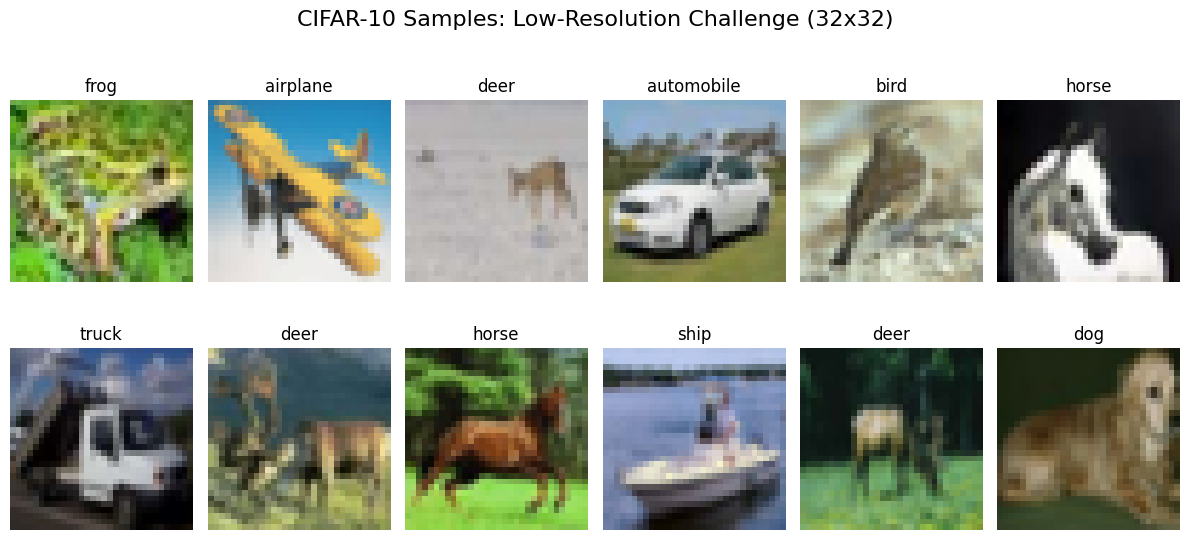

In [4]:
#@title Data Verification
import matplotlib.pyplot as plt
import numpy as np

# CIFAR-10 Class names
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

# Define unnormalization for visualization
# Based on dm.transform_train normalization constants
def unnormalize(img):
    img = img.clone()
    img[0] = img[0] * 0.2023 + 0.4914
    img[1] = img[1] * 0.1994 + 0.4822
    img[2] = img[2] * 0.2010 + 0.4465
    return img.clamp(0, 1) # Added clamp to ensure values are within [0, 1]


# Initialize DataModule
dm = GPUCIFAR10DataModule(batch_size=BATCH_SIZE)
dm.setup()

# Get a batch of data
batch = next(iter(dm.train_dataloader()))
images, labels = batch

# Plot a grid
plt.figure(figsize=(12, 6))
for i in range(12):
    plt.subplot(2, 6, i + 1)
    img = unnormalize(images[i])
    plt.imshow(np.transpose(img.cpu().numpy(), (1, 2, 0)))
    plt.title(classes[labels[i]])
    plt.axis('off')

plt.suptitle("CIFAR-10 Samples: Low-Resolution Challenge (32x32)", fontsize=16)
plt.tight_layout()
plt.show()

> 🛑 **Checkpoint 1**
>
> Are you visualizing a similar output?

## Part 1: Training the Teacher

Let's now define the architecture of the teacher:

In [5]:
import torch.nn as nn

class TeacherModel(nn.Module):
    """
    The 'Deep' Teacher: Overparameterized to find high-performing solutions.
    Based on the architecture from the PyTorch KD tutorial.
    """
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Flatten(),
            nn.Linear(64 * 8 * 8, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        return self.features(x)

# Initialize models and count parameters
teacher = TeacherModel()

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Teacher Parameters: {count_parameters(teacher):,}")

Teacher Parameters: 545,098


As we can see, the model is very simple, but it will serve our purposes.

### Training the Teacher

Let us now define the PyTorch Lightning module to train the Teacher:

> ☑️ **TODO 1**
>
> Implement the `TeacherTask` class
>
> This class is responsible for training the teacher with a standard cross entropy loss.
> Fill in the missing parts below.

In [6]:
from torch import nn
import matplotlib.pyplot as plt
import pandas as pd

class TeacherTask(pl.LightningModule):
    def __init__(self, model, lr):
        super().__init__()
        self.model = model
        self.criterion = nn.CrossEntropyLoss() # Standard Hard Target objective
        self.lr = lr

        # Initialize lists to store metrics for plotting
        self.train_losses = []
        self.train_accs = []
        self.val_losses = []
        self.val_accs = []

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)

        # TODO: Standard loss and accuracy computation
        # define loss = ... and acc = ...
        # <YOUR CODE HERE>

        # </YOUR CODE HERE>

        self.log("teacher/train_loss", loss, prog_bar=True)
        self.log("teacher/train_acc", acc, prog_bar=True)
        self.train_losses.append(loss.item())
        self.train_accs.append(acc.item())
        return loss

    def validation_step(self, batch, batch_idx):
        # TODO: insert validation code
        # define loss and acc
        # <YOUR CODE HERE>
        
        # </YOUR CODE HERE>
        self.log("teacher/val_loss", loss)
        self.log("teacher/val_acc", acc)
        self.val_losses.append(loss.item())
        self.val_accs.append(acc.item())

    def configure_optimizers(self):
        # TODO: define and return the optimizer
        # <YOUR CODE HERE>
        
        # </YOUR CODE HERE>

teacher_task = TeacherTask(teacher, lr = LR)
trainer = pl.Trainer(
    max_epochs=MAX_EPOCHS,
    accelerator="auto",
    devices=1,
    logger=WandbLogger(project=WANDB_PROJECT, name="Teacher-Baseline")
)

trainer.fit(teacher_task, dm)

# Evaluate the teacher baseline model on the test set
print("\n🚀 Running final evaluation on the teacher baseline test set...")
# Use trainer.validate because TeacherTask does not implement test_step
baseline_test_results = trainer.validate(teacher_task, dm)

# Extract the final accuracies
final_baseline_test_accuracy = baseline_test_results[0]['teacher/val_acc'] # Logged as 'teacher/val_acc' in TeacherTask
final_baseline_train_accuracy = teacher_task.train_accs[-1]

# Create a DataFrame to display the results
baseline_results_df = pd.DataFrame({
    'Metric': ['Teacher Baseline Training Accuracy', 'Teacher Baseline Test Accuracy'],
    'Value': [f'{final_baseline_train_accuracy:.4f}', f'{final_baseline_test_accuracy:.4f}']
})

wandb.finish() # terminate previous runs (if any)
print("\n🏁 Teacher Baseline Model Performance:")
print(baseline_results_df.to_string(index=False))

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
INFO:pytorch_lightning.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
wandb: WARNING The anonymous setting has no effect and will be removed in a future version.


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name      ┃ Type             ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model     │ TeacherModel     │  545 K │ train │     0 │
│ 1 │ criterion │ CrossEntropyLoss │      0 │ train │     0 │
└───┴───────────┴──────────────────┴────────┴───────┴───────┘

Trainable params: 545 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 545 K                                                                                                
Total estimated model params size (MB): 2                                                                          
Modules in train mode: 13                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

/usr/local/lib/python3.12/dist-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)`
is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.



🚀 Running final evaluation on the teacher baseline test set...


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      teacher/val_acc      │    0.6985999941825867     │
│     teacher/val_loss      │    0.8505196571350098     │
└───────────────────────────┴───────────────────────────┘

epoch,▁▁▂▂▂▂▂▂▃▃▃▄▄▄▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇█
teacher/train_acc,▁▂▃▄▂▄▅▄▇▆▄▆▇▇▆▆▇▆█
teacher/train_loss,█▇▆▅▇▅▄▅▃▃▅▃▂▁▂▃▂▃▁
teacher/val_acc,▁▃▅▆▇▇█▇███
teacher/val_loss,█▆▄▃▃▂▂▂▁▁▁
trainer/global_step,▁▁▁▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▆▆▆▆▇▇▇▇▇███
epoch,10
teacher/train_acc,0.7207
teacher/train_loss,0.81979
teacher/val_acc,0.6986
teacher/val_loss,0.85052



🏁 Teacher Baseline Model Performance:
                            Metric  Value
Teacher Baseline Training Accuracy 0.6994
    Teacher Baseline Test Accuracy 0.6986


Let's visualize training curves for a check:

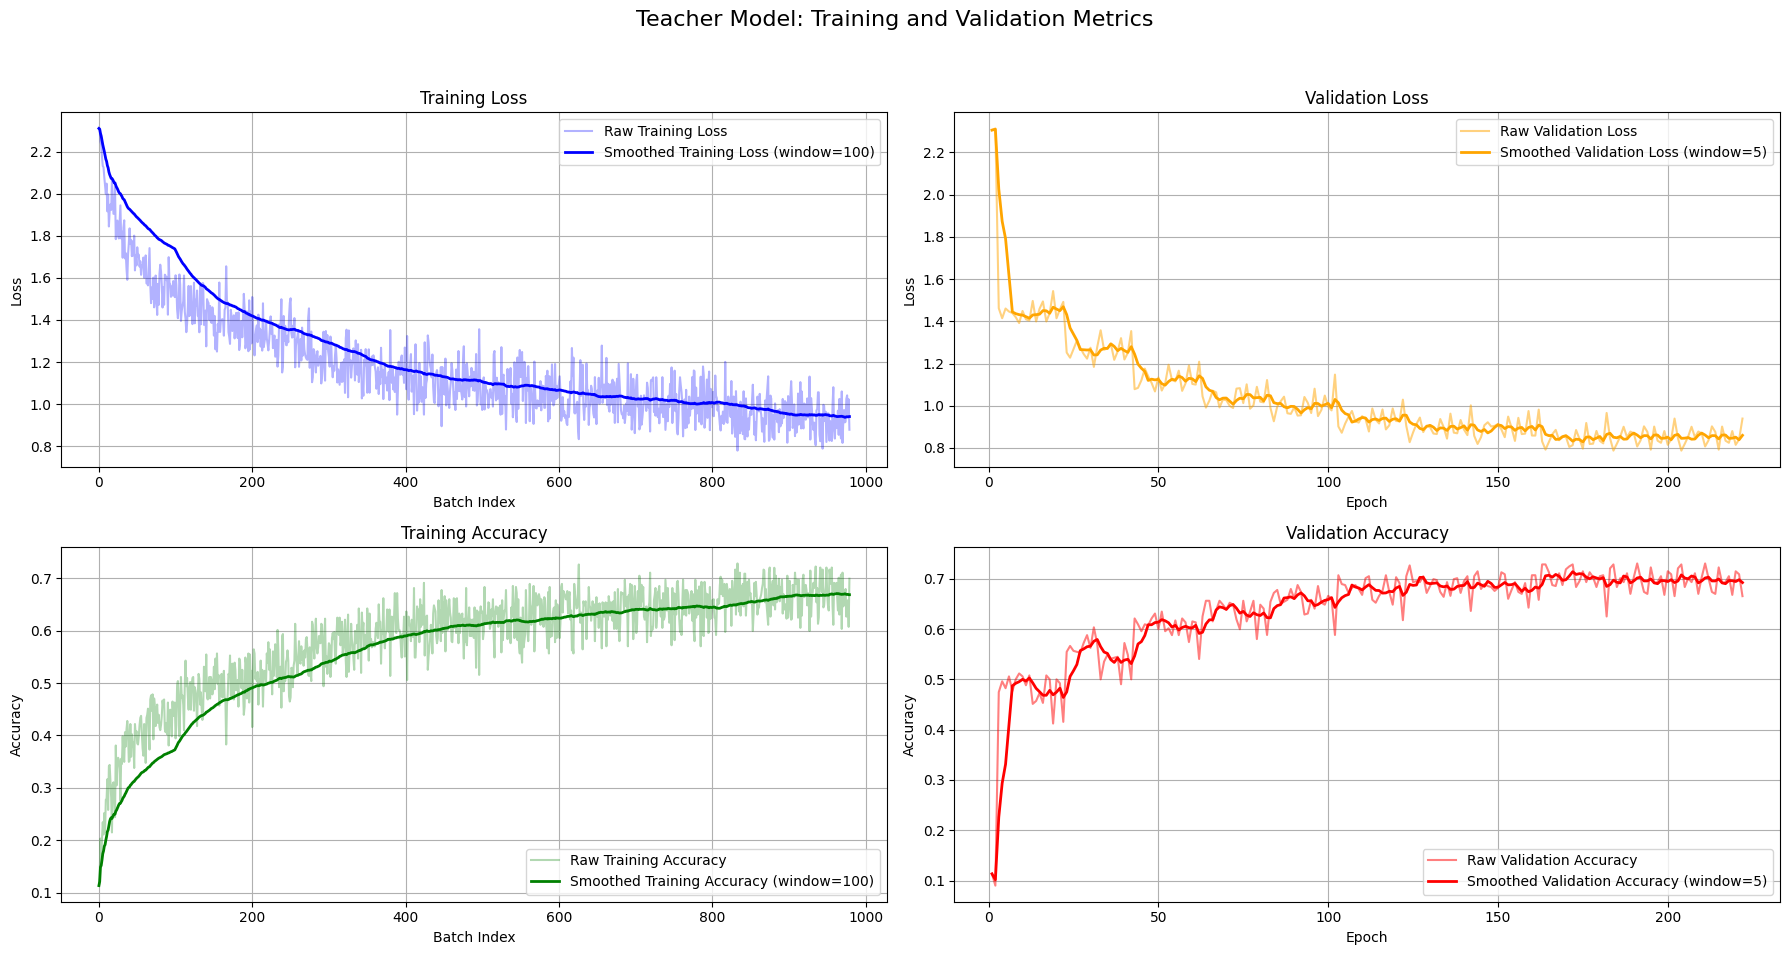

In [7]:
#@title Training Curves
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd # Required for rolling mean for smoothing

def plot_training_curves(teacher_task):
    # Get data from the trained teacher_task
    train_losses = teacher_task.train_losses
    train_accs = teacher_task.train_accs
    val_losses = teacher_task.val_losses
    val_accs = teacher_task.val_accs

    # Define smoothing window sizes
    # Training metrics are per batch, so a larger window is appropriate
    smoothing_window_train = 100
    # Validation metrics are per epoch, typically fewer points, so a smaller window or no smoothing
    smoothing_window_val = 5 # Changed to 5 to enable smoothing for validation

    # Create figure and 2x2 subplots
    fig, axes = plt.subplots(2, 2, figsize=(18, 10))
    fig.suptitle('Teacher Model: Training and Validation Metrics', fontsize=16)

    # --- Plot 1: Training Loss ---
    axes[0, 0].plot(train_losses, color='blue', alpha=0.3, label='Raw Training Loss')
    smoothed_train_loss = pd.Series(train_losses).rolling(window=smoothing_window_train, min_periods=1).mean()
    axes[0, 0].plot(smoothed_train_loss, color='blue', linewidth=2, label=f'Smoothed Training Loss (window={smoothing_window_train})')
    axes[0, 0].set_title('Training Loss')
    axes[0, 0].set_xlabel('Batch Index')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True)

    # --- Plot 2: Validation Loss ---
    epochs = np.arange(1, len(val_losses) + 1) # X-axis represents epochs
    axes[0, 1].plot(epochs, val_losses, color='orange', alpha=0.5, label='Raw Validation Loss')
    # Apply smoothing to validation metrics if the window size is greater than 1
    if smoothing_window_val > 1 and len(val_losses) >= smoothing_window_val:
        smoothed_val_loss = pd.Series(val_losses).rolling(window=smoothing_window_val, min_periods=1).mean()
        axes[0, 1].plot(epochs, smoothed_val_loss, color='orange', linewidth=2, label=f'Smoothed Validation Loss (window={smoothing_window_val})')
    axes[0, 1].set_title('Validation Loss')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Loss')
    axes[0, 1].legend()
    axes[0, 1].grid(True)

    # --- Plot 3: Training Accuracy ---
    axes[1, 0].plot(train_accs, color='green', alpha=0.3, label='Raw Training Accuracy')
    smoothed_train_acc = pd.Series(train_accs).rolling(window=smoothing_window_train, min_periods=1).mean()
    axes[1, 0].plot(smoothed_train_acc, color='green', linewidth=2, label=f'Smoothed Training Accuracy (window={smoothing_window_train})')
    axes[1, 0].set_title('Training Accuracy')
    axes[1, 0].set_xlabel('Batch Index')
    axes[1, 0].set_ylabel('Accuracy')
    axes[1, 0].legend()
    axes[1, 0].grid(True)

    # --- Plot 4: Validation Accuracy ---
    axes[1, 1].plot(epochs, val_accs, color='red', alpha=0.5, label='Raw Validation Accuracy')
    # Apply smoothing to validation metrics if the window size is greater than 1
    if smoothing_window_val > 1 and len(val_accs) >= smoothing_window_val:
        smoothed_val_acc = pd.Series(val_accs).rolling(window=smoothing_window_val, min_periods=1).mean()
        axes[1, 1].plot(epochs, smoothed_val_acc, color='red', linewidth=2, label=f'Smoothed Validation Accuracy (window={smoothing_window_val})')
    axes[1, 1].set_title('Validation Accuracy')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Accuracy')
    axes[1, 1].legend()
    axes[1, 1].grid(True)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to make room for suptitle
    plt.show()

plot_training_curves(teacher_task)

> 🛑 **Checkpoint 2**
>
> Are you visualizing similar training curves and obtaining similar test accuracy? Also check in Weight and Biases that your training is proceedings as expected.

### Exposing Dark Knowledge

Let's now visualize an example and the probabilities predicted by the teacher with different temperature values.

> ☑️ **TODO 2**
>
> Complete the logic below to add temperature.

Visualizing teacher predictions with Temperature = 1.0 (Standard Softmax)


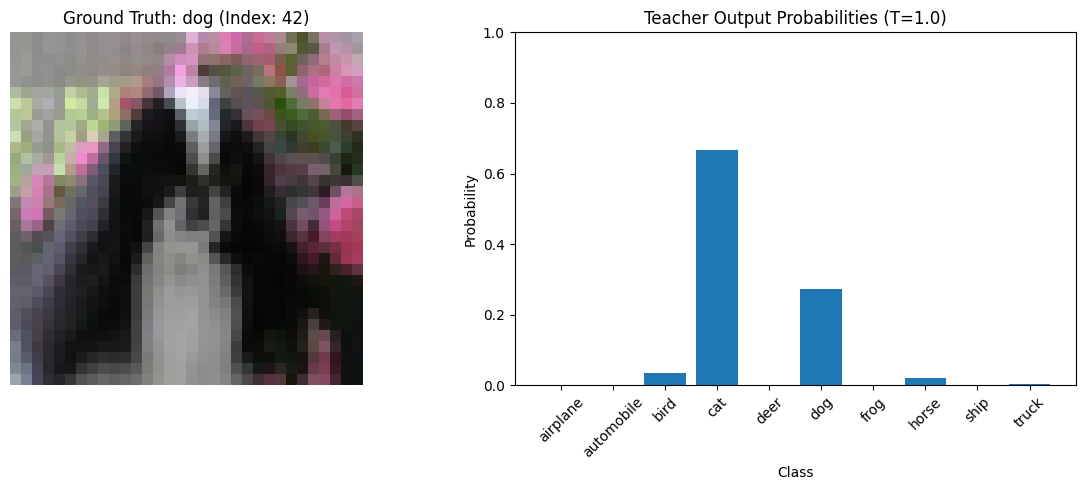


Visualizing teacher predictions with Temperature = 2.0


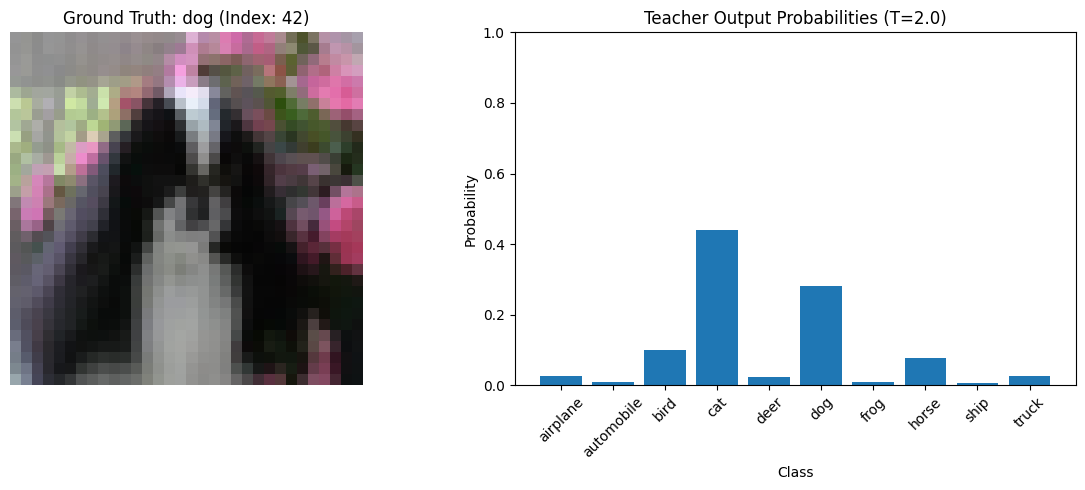


Visualizing teacher predictions with Temperature = 5.0


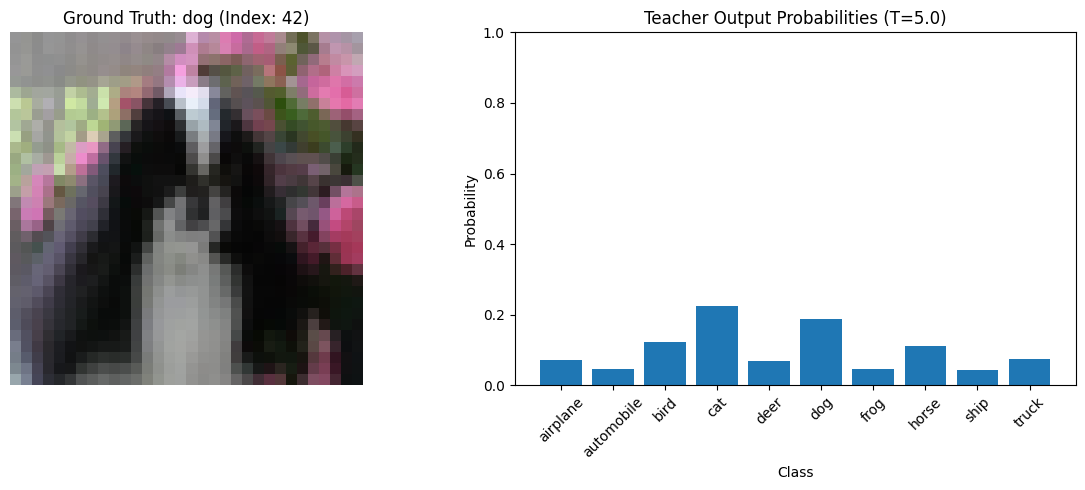

In [8]:
def visualize_teacher_prediction(teacher_model, datamodule, classes, temperature=1.0, idx=None):
    teacher_model.eval()
    # Ensure the model is on the correct device
    teacher_model.to(device)
    # Ensure data module is set up
    datamodule.setup()

    # Pick a specific example or a random one if idx is not provided
    if idx is None:
        # Access test_x and test_y directly from the datamodule
        idx = np.random.randint(0, len(datamodule.test_x))
    elif not (0 <= idx < len(datamodule.test_x)):
        raise ValueError(f"Index {idx} is out of bounds for dataset of size {len(datamodule.test_x)}")

    # Correctly access image and label from the datamodule's pre-loaded tensors
    image = datamodule.test_x[idx]
    label = datamodule.test_y[idx]

    # Add batch dimension and move to device (image is already on device from datamodule setup)
    input_image = image.unsqueeze(0)

    with torch.no_grad():
        logits = teacher_model(input_image)
        # TODO: apply temperature scaling and softmax
        # define the "probabilities" variable
        # <YOUR CODE HERE>
        
        # </YOUR CODE HERE>

    # Unnormalize image for display
    img_display = unnormalize(image.cpu())

    # Plotting
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    # Image
    ax1.imshow(np.transpose(img_display.numpy(), (1, 2, 0)))
    ax1.set_title(f'Ground Truth: {classes[label]} (Index: {idx})')
    ax1.axis('off')

    # Probability distribution
    ax2.bar(classes, probabilities.squeeze().cpu().numpy())
    ax2.set_xlabel('Class')
    ax2.set_ylabel('Probability')
    ax2.set_title(f'Teacher Output Probabilities (T={temperature})')
    ax2.set_ylim(0, 1)
    ax2.tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()

# Call the function with different temperatures and a fixed index for comparison
specific_index_to_plot = 42 # You can change this index to any valid number

print("Visualizing teacher predictions with Temperature = 1.0 (Standard Softmax)")
visualize_teacher_prediction(teacher_task.model, dm, classes, temperature=1.0, idx=specific_index_to_plot)

print("\nVisualizing teacher predictions with Temperature = 2.0")
visualize_teacher_prediction(teacher_task.model, dm, classes, temperature=2.0, idx=specific_index_to_plot)

print("\nVisualizing teacher predictions with Temperature = 5.0")
visualize_teacher_prediction(teacher_task.model, dm, classes, temperature=5.0, idx=specific_index_to_plot)

> 📝 **Reflection 2**
>
> <i>What's the effect of the temperature value? Experiment with other values and report what happens when a temperature lower than 1 and larger than 100 is used.</i>
>
> Your text

> 🏁 **Milestone 1**
>
> You completed part 1! Your Teacher model should be working well now.

## Part 2: Student baseline
Let us now define the student model:

> ☑️ **TODO 3**
>
> Implement the `StudentModel` class
>
> This should have the following architecture:
> - A convolutional layer (3 input channels, 16 output channels, 3x3 kernel, 1 padding)
> - A ReLU activation and a 2x2 max pooling layer
> - Another convolutional layer (16 input channels, 16 output channels, 3x3 kernel, 1 padding)
> - A ReLU activation, and another 2x2 max pooling layer
> - The output is flattened and passed through a linear layer with 1024 input features and 256 output features followed by ReLU and a 0.1 dropout layer.
>- Finally, it has an output linear layer with 256 input features and num_class output classes.
>
> Fill in the missing parts in the code below.

In [10]:
import torch.nn as nn

class StudentModel(nn.Module):
    """
    The 'Deep' Teacher: Overparameterized to find high-performing solutions.
    Based on the architecture from the PyTorch KD tutorial.
    """
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 6, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(6, 12, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Flatten(),
            nn.Linear(12 * 8 * 8, 24),
            nn.ReLU(),
            nn.Linear(24, 10)
        )

    def forward(self, x):
        return self.features(x)

# Initialize models and count parameters
student = StudentModel()

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Teacher Parameters: {count_parameters(student):,}")

Teacher Parameters: 19,534


> 📝 **Reflection 3**
>
> <i>Compare the architecture of the student with the one of the teacher. What are the differences? Which of the two has less parameters?</i>
>
> Your text

### Student Baseline
Let's train the student directly:

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
INFO:pytorch_lightning.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.



🚀 Starting student baseline training (without distillation)...


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name      ┃ Type             ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model     │ StudentModel     │ 19.5 K │ train │     0 │
│ 1 │ criterion │ CrossEntropyLoss │      0 │ train │     0 │
└───┴───────────┴──────────────────┴────────┴───────┴───────┘

Trainable params: 19.5 K                                                                                           
Non-trainable params: 0                                                                                            
Total params: 19.5 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 13                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

/usr/local/lib/python3.12/dist-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)`
is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.



🚀 Running final evaluation on the student baseline test set...


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      teacher/val_acc      │    0.5175999999046326     │
│     teacher/val_loss      │    1.3536016941070557     │
└───────────────────────────┴───────────────────────────┘


🏁 Student Baseline Model Performance:
                            Metric  Value
Student Baseline Training Accuracy 0.4613
    Student Baseline Test Accuracy 0.5176


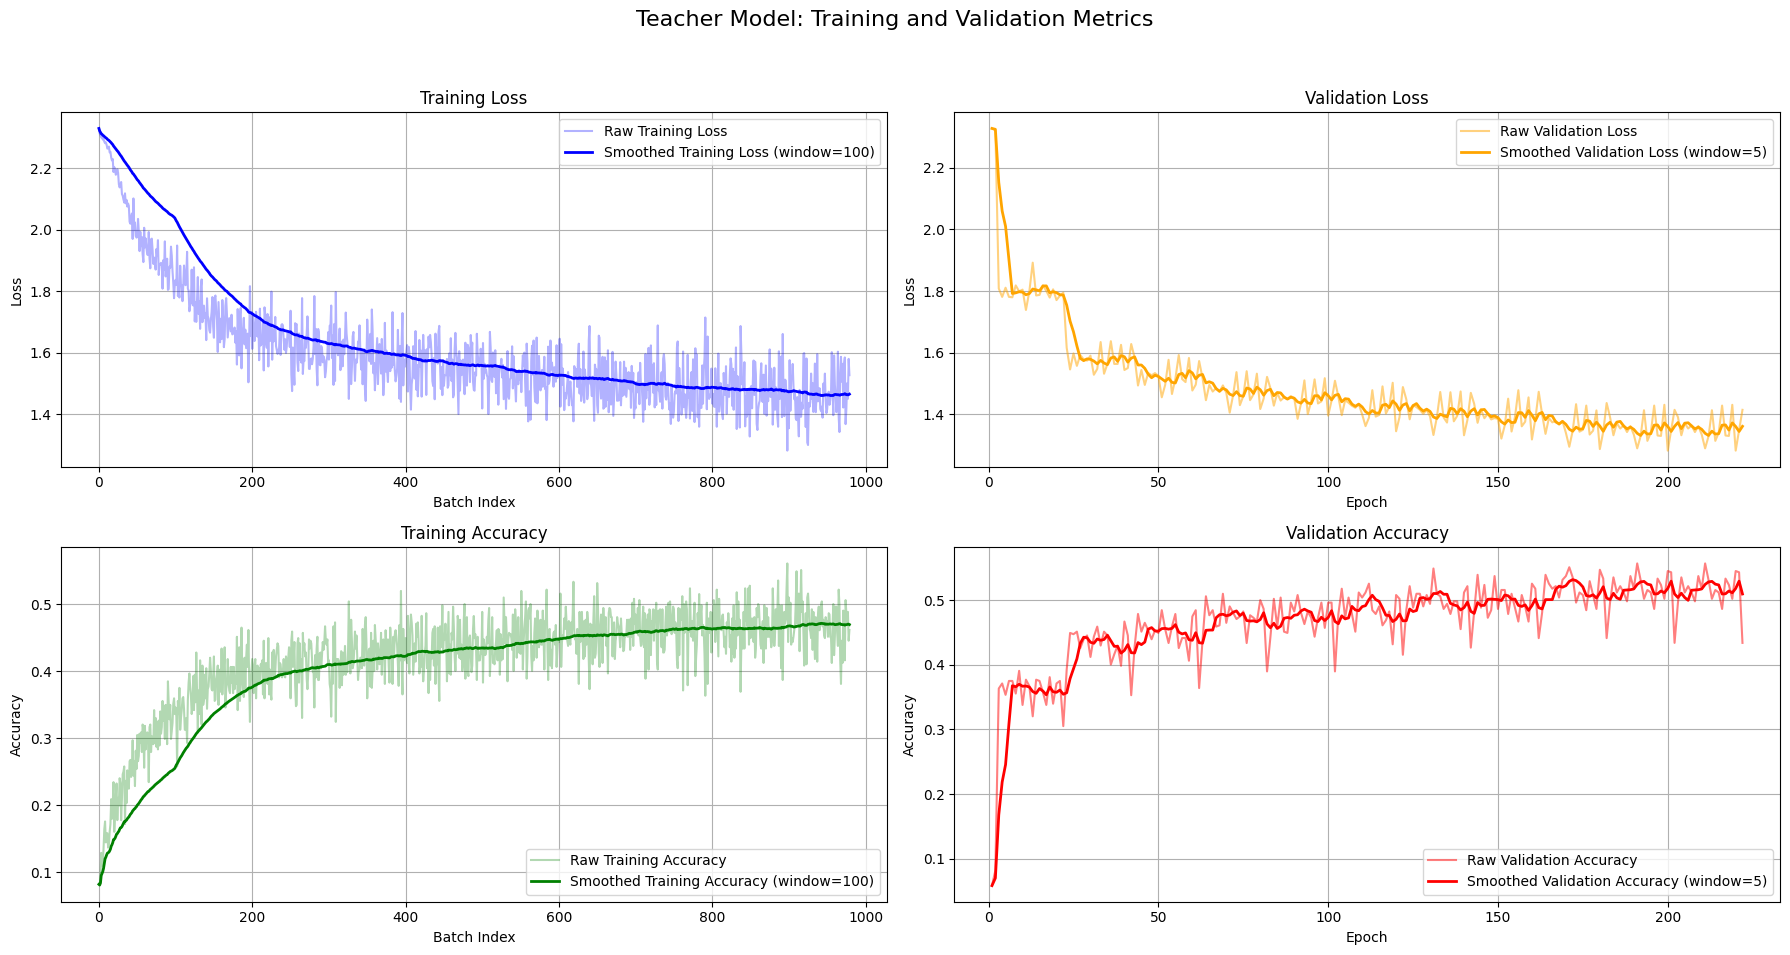

In [11]:
print("\n🚀 Starting student baseline training (without distillation)...")

# Initialize a new instance of the StudentModel for baseline training
student_baseline_model = StudentModel().to(device)

# Use the TeacherTask for training the student baseline, as it performs standard classification training
student_baseline_task = TeacherTask(student_baseline_model, lr=LR)

wandb.finish() # terminate previous runs (if any)

# Create a new Trainer instance for the student baseline
student_baseline_trainer = pl.Trainer(
    max_epochs=MAX_EPOCHS,
    accelerator="auto",
    devices=1,
    logger=WandbLogger(project=WANDB_PROJECT, name="Student-Baseline")
)

# Train the student baseline model
student_baseline_trainer.fit(student_baseline_task, dm)

# Evaluate the student baseline model on the test set
print("\n🚀 Running final evaluation on the student baseline test set...")
# Use trainer.validate because TeacherTask does not implement test_step
baseline_test_results = student_baseline_trainer.validate(student_baseline_task, dm)

# Extract the final accuracies
final_baseline_test_accuracy = baseline_test_results[0]['teacher/val_acc'] # Logged as 'teacher/val_acc' in TeacherTask
final_baseline_train_accuracy = student_baseline_task.train_accs[-1]

# Create a DataFrame to display the results
baseline_results_df = pd.DataFrame({
    'Metric': ['Student Baseline Training Accuracy', 'Student Baseline Test Accuracy'],
    'Value': [f'{final_baseline_train_accuracy:.4f}', f'{final_baseline_test_accuracy:.4f}']
})

print("\n🏁 Student Baseline Model Performance:")
print(baseline_results_df.to_string(index=False))
plot_training_curves(student_baseline_task)

> 🛑 **Checkpoint 3**
>
> Are you visualizing similar training curves and obtaining similar test accuracy? Also check in Weight and Biases that your training is proceedings as expected.

> 📝 **Reflection 4**
>
> <i>Compare the performance of the teacher and student. Which of the two is working best? Why?</i>
>
> Your text

> 🏁 **Milestone 2**
>
> You completed part 2! Your Student model should be working well and ready to be distilled from the teacher.

## Part 3: Response-Based Distillation

Let us now define the response-based distillation task:

> ☑️ **TODO 4**
>
> Implement the `DistillationTask` class
>
> Follow the instructions below to fill in the gaps.

In [12]:
class DistillationTask(pl.LightningModule):
    def __init__(self, teacher_model, student_model, temperature, alpha, lr):
        super().__init__()
        self.teacher_model = teacher_model
        self.student_model = student_model
        self.temperature = temperature
        self.alpha = alpha # Weight for hard target loss
        self.lr = lr

        # Freeze teacher parameters
        for param in self.teacher_model.parameters():
            param.requires_grad = False
        self.teacher_model.eval()

        # TODO: Define the two loss functions (use standard losses from nn)
        # self.hard_criterion = ...
        # self.distillation_criterion = ...
        # <YOUR CODE HERE>
        
        # </YOUR CODE HERE>

        # Initialize lists to store metrics for plotting
        self.train_total_losses = []
        self.train_hard_losses = []
        self.train_distillation_losses = []
        self.train_accs = []

        self.val_total_losses = []
        self.val_hard_losses = []
        self.val_distillation_losses = []
        self.val_accs = []

    def forward(self, x):
        return self.student_model(x)

    def _compute_losses(self, student_logits, teacher_logits, labels):
        # Hard target loss
        hard_loss = self.hard_criterion(student_logits, labels)


        # TODO: Define the soft teacher probabilities and the soft student log probabilities
        # Hint: use F.softmax and F.log_softmax
        # Do not forget to add tempertature
        # <YOUR CODE HERE>
        
        # </YOUR CODE HERE>


        # TODO: Define the distillation loss (check slides for hint)
        # <YOUR CODE HERE>
        
        # </YOUR CODE HERE>

        # TODO: Define the total loss
        # This is a combination of the hard loss (cross entropy) and distilaltion loss
        # with weights alpha and 1-alpha
        # <YOUR CODE HERE>
        
        # </YOUR CODE HERE>

        return total_loss, hard_loss, distillation_loss

    def training_step(self, batch, batch_idx):
        x, y = batch

        # Get teacher logits (no grad)
        with torch.no_grad():
            teacher_logits = self.teacher_model(x)

        # Get student logits
        student_logits = self.student_model(x)

        total_loss, hard_loss, distillation_loss = self._compute_losses(student_logits, teacher_logits, y)

        acc = (student_logits.argmax(1) == y).float().mean()

        self.log("student_kd/train_total_loss", total_loss, prog_bar=True)
        self.log("student_kd/train_hard_loss", hard_loss)
        self.log("student_kd/train_distillation_loss", distillation_loss)
        self.log("student_kd/train_acc", acc, prog_bar=True)

        self.train_total_losses.append(total_loss.item())
        self.train_hard_losses.append(hard_loss.item())
        self.train_distillation_losses.append(distillation_loss.item())
        self.train_accs.append(acc.item())
        return total_loss

    def validation_step(self, batch, batch_idx):
        x, y = batch

        with torch.no_grad():
            teacher_logits = self.teacher_model(x)
        student_logits = self.student_model(x)

        total_loss, hard_loss, distillation_loss = self._compute_losses(student_logits, teacher_logits, y)

        acc = (student_logits.argmax(1) == y).float().mean()

        self.log("student_kd/val_total_loss", total_loss)
        self.log("student_kd/val_hard_loss", hard_loss)
        self.log("student_kd/val_distillation_loss", distillation_loss)
        self.log("student_kd/val_acc", acc)

        self.val_total_losses.append(total_loss.item())
        self.val_hard_losses.append(hard_loss.item())
        self.val_distillation_losses.append(distillation_loss.item())
        self.val_accs.append(acc.item())
        return total_loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.student_model.parameters(), lr=self.lr)
        return optimizer

Let's now perform the training:

In [13]:
# Define hyperparameters for distillation
DISTILLATION_TEMPERATURE = 1.0  # Temperature for softening teacher probabilities -> setting to 1 as probabilities are already "soft" due to under-training
DISTILLATION_ALPHA = 0.7        # Weight for hard target loss (0.0 to 1.0)

# Initialize the student model (already done, but re-initialize for clarity if needed)
student_model = StudentModel().to(device)

# Instantiate the DistillationTask
distillation_task = DistillationTask(
    teacher_model=teacher_task.model, # Use the trained teacher model
    student_model=student_model,
    temperature=DISTILLATION_TEMPERATURE,
    alpha=DISTILLATION_ALPHA,
    lr=LR
)

# Instantiate the PyTorch Lightning Trainer for the student
student_trainer = pl.Trainer(
    max_epochs=MAX_EPOCHS,
    accelerator="auto",
    devices=1,
    logger=WandbLogger(project=WANDB_PROJECT, name="Student-Distillation")
)

wandb.finish() # terminate previous runs (if any)

print("\n🚀 Starting student training with Knowledge Distillation...")
student_trainer.fit(distillation_task, dm)

# Evaluate the distilled student on the test set
print("\n🚀 Running final evaluation of the the distilled student on the test set...")
# Use trainer.validate because TeacherTask does not implement test_step
baseline_test_results = student_trainer.validate(distillation_task, dm)

# Extract the final accuracies
final_baseline_test_accuracy = baseline_test_results[0]['student_kd/val_acc'] # Logged as 'teacher/val_acc' in TeacherTask
final_baseline_train_accuracy = distillation_task.train_accs[-1]

# Create a DataFrame to display the results
baseline_results_df = pd.DataFrame({
    'Metric': ['Distilled Student Training Accuracy', 'Distilled Student Test Accuracy'],
    'Value': [f'{final_baseline_train_accuracy:.4f}', f'{final_baseline_test_accuracy:.4f}']
})

print("\n🏁 Distilled Student Performance:")
print(baseline_results_df.to_string(index=False))

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.


epoch,▁▁▂▂▂▂▂▂▃▃▃▄▄▄▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇█
teacher/train_acc,▁▃▅▅▅▅▆▅▆▅▆▆▆▇▇▅█▆▇
teacher/train_loss,█▆▅▅▄▅▄▃▄▄▃▄▃▂▂▃▁▃▂
teacher/val_acc,▁▄▅▆▆▇▇▇███
teacher/val_loss,█▅▄▃▃▂▂▂▁▁▁
trainer/global_step,▁▁▁▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▆▆▆▆▇▇▇▇▇███
epoch,10
teacher/train_acc,0.47266
teacher/train_loss,1.40399
teacher/val_acc,0.5176
teacher/val_loss,1.3536


INFO:pytorch_lightning.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.



🚀 Starting student training with Knowledge Distillation...


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name                   ┃ Type             ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ teacher_model          │ TeacherModel     │  545 K │ eval  │     0 │
│ 1 │ student_model          │ StudentModel     │ 19.5 K │ train │     0 │
│ 2 │ hard_criterion         │ CrossEntropyLoss │      0 │ train │     0 │
│ 3 │ distillation_criterion │ KLDivLoss        │      0 │ train │     0 │
└───┴────────────────────────┴──────────────────┴────────┴───────┴───────┘

Trainable params: 19.5 K                                                                                           
Non-trainable params: 545 K                                                                                        
Total params: 564 K                                                                                                
Total estimated model params size (MB): 2                                                                          
Modules in train mode: 14                                                                                          
Modules in eval mode: 12                                                                                           
Total FLOPs: 0

Output()

/usr/local/lib/python3.12/dist-packages/pytorch_lightning/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)`
is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.

/usr/local/lib/python3.12/dist-packages/pytorch_lightning/loops/fit_loop.py:534: Found 12 module(s) in eval mode at
the start of training. This may lead to unexpected behavior during training. If this is intentional, you can ignore
this warning.

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.



🚀 Running final evaluation of the the distilled student on the test set...


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃         Validate metric          ┃           DataLoader 0           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        student_kd/val_acc        │        0.5263000130653381        │
│ student_kd/val_distillation_loss │       0.44938281178474426        │
│     student_kd/val_hard_loss     │        1.3298882246017456        │
│    student_kd/val_total_loss     │        1.0657366514205933        │
└──────────────────────────────────┴──────────────────────────────────┘


🏁 Distilled Student Performance:
                             Metric  Value
Distilled Student Training Accuracy 0.5298
    Distilled Student Test Accuracy 0.5263


Let's plot the training curves:

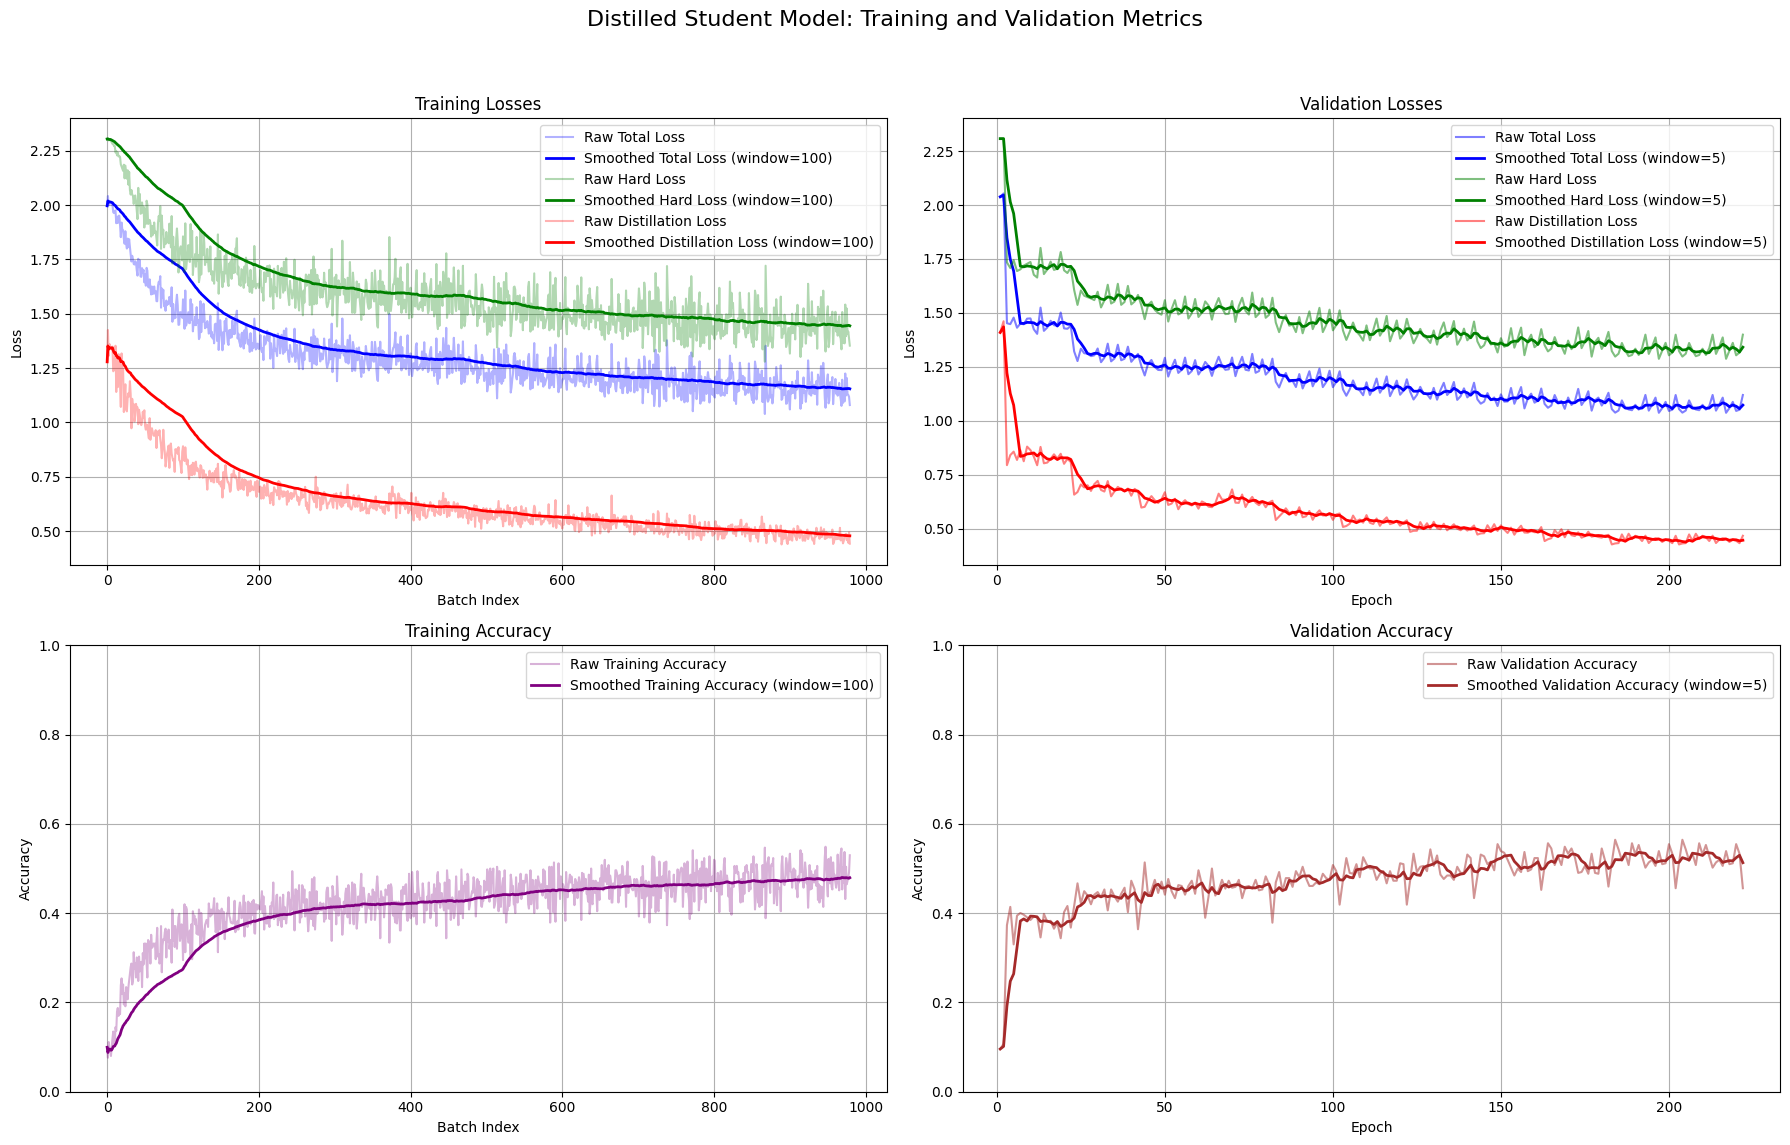

In [14]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd # Required for rolling mean for smoothing

def plot_distillation_curves(distillation_task):
    # Get data from the trained distillation_task
    train_total_losses = distillation_task.train_total_losses
    train_hard_losses = distillation_task.train_hard_losses
    train_distillation_losses = distillation_task.train_distillation_losses
    train_accs = distillation_task.train_accs

    val_total_losses = distillation_task.val_total_losses
    val_hard_losses = distillation_task.val_hard_losses
    val_distillation_losses = distillation_task.val_distillation_losses
    val_accs = distillation_task.val_accs

    # Define smoothing window sizes
    smoothing_window_train = 100
    smoothing_window_val = 5

    # Create figure and subplots
    fig, axes = plt.subplots(2, 2, figsize=(18, 12))
    fig.suptitle('Distilled Student Model: Training and Validation Metrics', fontsize=16)

    # --- Plot 1: Training Losses (Total, Hard, Distillation) ---
    axes[0, 0].plot(train_total_losses, color='blue', alpha=0.3, label='Raw Total Loss')
    smoothed_train_total_loss = pd.Series(train_total_losses).rolling(window=smoothing_window_train, min_periods=1).mean()
    axes[0, 0].plot(smoothed_train_total_loss, color='blue', linewidth=2, label=f'Smoothed Total Loss (window={smoothing_window_train})')

    axes[0, 0].plot(train_hard_losses, color='green', alpha=0.3, label='Raw Hard Loss')
    smoothed_train_hard_loss = pd.Series(train_hard_losses).rolling(window=smoothing_window_train, min_periods=1).mean()
    axes[0, 0].plot(smoothed_train_hard_loss, color='green', linewidth=2, label=f'Smoothed Hard Loss (window={smoothing_window_train})')

    axes[0, 0].plot(train_distillation_losses, color='red', alpha=0.3, label='Raw Distillation Loss')
    smoothed_train_distillation_loss = pd.Series(train_distillation_losses).rolling(window=smoothing_window_train, min_periods=1).mean()
    axes[0, 0].plot(smoothed_train_distillation_loss, color='red', linewidth=2, label=f'Smoothed Distillation Loss (window={smoothing_window_train})')

    axes[0, 0].set_title('Training Losses')
    axes[0, 0].set_xlabel('Batch Index')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True)

    # --- Plot 2: Validation Losses (Total, Hard, Distillation) ---
    epochs = np.arange(1, len(val_total_losses) + 1)
    axes[0, 1].plot(epochs, val_total_losses, color='blue', alpha=0.5, label='Raw Total Loss')
    if smoothing_window_val > 1 and len(val_total_losses) >= smoothing_window_val:
        smoothed_val_total_loss = pd.Series(val_total_losses).rolling(window=smoothing_window_val, min_periods=1).mean()
        axes[0, 1].plot(epochs, smoothed_val_total_loss, color='blue', linewidth=2, label=f'Smoothed Total Loss (window={smoothing_window_val})')

    axes[0, 1].plot(epochs, val_hard_losses, color='green', alpha=0.5, label='Raw Hard Loss')
    if smoothing_window_val > 1 and len(val_hard_losses) >= smoothing_window_val:
        smoothed_val_hard_loss = pd.Series(val_hard_losses).rolling(window=smoothing_window_val, min_periods=1).mean()
        axes[0, 1].plot(epochs, smoothed_val_hard_loss, color='green', linewidth=2, label=f'Smoothed Hard Loss (window={smoothing_window_val})')

    axes[0, 1].plot(epochs, val_distillation_losses, color='red', alpha=0.5, label='Raw Distillation Loss')
    if smoothing_window_val > 1 and len(val_distillation_losses) >= smoothing_window_val:
        smoothed_val_distillation_loss = pd.Series(val_distillation_losses).rolling(window=smoothing_window_val, min_periods=1).mean()
        axes[0, 1].plot(epochs, smoothed_val_distillation_loss, color='red', linewidth=2, label=f'Smoothed Distillation Loss (window={smoothing_window_val})')

    axes[0, 1].set_title('Validation Losses')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Loss')
    axes[0, 1].legend()
    axes[0, 1].grid(True)

    # --- Plot 3: Training Accuracy ---
    axes[1, 0].plot(train_accs, color='purple', alpha=0.3, label='Raw Training Accuracy')
    smoothed_train_acc = pd.Series(train_accs).rolling(window=smoothing_window_train, min_periods=1).mean()
    axes[1, 0].plot(smoothed_train_acc, color='purple', linewidth=2, label=f'Smoothed Training Accuracy (window={smoothing_window_train})')
    axes[1, 0].set_title('Training Accuracy')
    axes[1, 0].set_xlabel('Batch Index')
    axes[1, 0].set_ylabel('Accuracy')
    axes[1, 0].set_ylim(0, 1) # Accuracy is between 0 and 1
    axes[1, 0].legend()
    axes[1, 0].grid(True)

    # --- Plot 4: Validation Accuracy ---
    axes[1, 1].plot(epochs, val_accs, color='brown', alpha=0.5, label='Raw Validation Accuracy')
    if smoothing_window_val > 1 and len(val_accs) >= smoothing_window_val:
        smoothed_val_acc = pd.Series(val_accs).rolling(window=smoothing_window_val, min_periods=1).mean()
        axes[1, 1].plot(epochs, smoothed_val_acc, color='brown', linewidth=2, label=f'Smoothed Validation Accuracy (window={smoothing_window_val})')
    axes[1, 1].set_title('Validation Accuracy')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Accuracy')
    axes[1, 1].set_ylim(0, 1) # Accuracy is between 0 and 1
    axes[1, 1].legend()
    axes[1, 1].grid(True)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to make room for suptitle
    plt.show()

plot_distillation_curves(distillation_task)

> 🛑 **Checkpoint 3**
>
> Are you visualizing similar training curves and obtaining similar test accuracy? Also check in Weight and Biases that your training is proceedings as expected.

> 📝 **Reflection 5**
>
> <i>Compare the results obtained in the different training runs and summarize them below. What is happening? Which model achieves the best performance? Which one is more effective in terms of parameter counts and accuracy?</i>
>
> Your text

> 🏁 **Milestone 3**
>
> You completed part 3! Your model should now be succesfully distilled.

## 🚀 Part 4: Extensions & Homework

Now that you have implemented Response-Based Knowledge Distillation, here are some challenging extensions to deepen your understanding.

### 📝 1. Hyperparameter Ablation for KD
We used fixed values for Temperature ($T$) and Alpha ($\alpha$).
*   **Task:** Perform an ablation study on these hyperparameters.
    *   **Temperature ($T$):** Experiment with a wider range of $T$ values (e. g., $T=1, 2, 5, 10, 20$). Observe how the softness of teacher probabilities affects the student's learning and final accuracy.
    *   **Alpha ($\alpha$):** Vary $\alpha$ (e.g., $\alpha=0.1, 0.5, 0.9$). Understand its impact on the balance between hard label learning and soft target imitation. How does it affect convergence and final performance?
*   **Comparison:** Summarize your findings. Which combination of $T$ and $\alpha$ yields the best student performance? Why?

### 🧪 2. Implement Feature-Based Distillation
Response-Based Distillation uses the teacher's final logits. An alternative is to transfer knowledge from intermediate layers.
*   **Task:** Implement a feature-based distillation method. This could involve:
    *   Matching the hidden representations of the teacher and student models (e.g., using L2 loss on outputs of a specific intermediate layer).
    *   Employing techniques like FitNets, where the student learns to predict the teacher's intermediate features.
*   **The Challenge:** You will need to modify the `StudentModel` and `TeacherModel` to expose intermediate features, and adapt the `DistillationTask` to include this new loss term.
*   **Comparison:** How does feature-based distillation compare to response-based distillation in terms of student performance and training stability?

### 🔍 3. Experiment with Different Student/Teacher Architectures
*   **Task:** Try different combinations of student and teacher models.
    *   **Smaller Student:** Use an even smaller student model (e.g., with fewer layers or channels) to push the limits of compression. Can it still benefit from distillation?
    *   **Stronger Teacher:** Use a pre-trained, larger model (e.g., a ResNet from `torchvision.models`) as the teacher. Does a more powerful teacher lead to a more capable student?
*   **Question:** What are the trade-offs between model size, performance, and the effectiveness of distillation for various architectures?

### 🛠️ 4. Multi-Teacher Distillation or Online Distillation
*   **Task:** Explore more advanced distillation techniques:
    *   **Multi-Teacher Distillation:** Can you distill knowledge from multiple teachers (e.g., an ensemble of models or models trained for different sub-tasks)? How would you combine their knowledge?
    *   **Online Distillation:** Instead of a pre-trained teacher, explore methods where teacher and student are trained simultaneously (e.g., one student teaching another, or a student-teacher pair learning together).
*   **The Challenge:** These methods require significant changes to the training loop and loss functions.

---
**Submission:**
Please wrap up your code, ensure your WandB logs are synced and you link is in the notebook, and submit your notebook via email.
